To begin upload this notebook to your own drive:

### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Run all cells** (in the menubar, select Runtime$\rightarrow$Run All).
3. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
4. **Upload the downloaded notebook (.ipynb file) to your repository**.

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

# ![shakespeare](https://i.imgur.com/81YZuel.jpg)

# Generating Shakespeare Using a Character-level Language Model

### From Words to Characters
In the previous section we dealt with word-level language models. But looking again at section 1, there is nothing that constraints us to using _words_ as the basic elemnents in our model. The model we analyzed in section 1 could just as well be character-based - just replace "word" with "character", and you are good to go. In this notebook we will train a small character-based language model that will help us generate Shakespearean-like (emphasis on the _like_...) texts.

### Question 2.a
Can you think of an advantage a character-based language model could have over a word-based language model? And what about the other way around: can you think of an advantage a word-based language model could have over a character-based language model? (Add your answer to the final submission pdf).

### Using PyTorch

We'll build our language model using PyTorch. PyTorch is a [very popular](https://thegradient.pub/state-of-ml-frameworks-2019-pytorch-dominates-research-tensorflow-dominates-industry/) open-source machine learning (and deep learning) framework developed by Facebook. In short:

> Pytorch is a Python-based scientific computing package targeted at two sets of audiences:
* A replacement for NumPy to use the power of GPUs
* A deep learning research platform that provides maximum flexibility and speed

To get familiar with PyTorch, check out this [quick tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html). In addition, another imporant difference from numpy is that PyTorch can automatically calculate the gradients needed for backpropagation, as explained [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

### Preparing the Data

Our dataset is a plain text file. For simplicity, we turn any potential unicode characters into plain ASCII by using the `unidecode` package.

In [1]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.1 MB/s eta 0:00:00


In [2]:
import string
import random
import re
import requests
import unidecode
url = "https://github.com/tau-nlp-course/NLP_HW2/raw/main/data/shakespeare.txt"


all_characters = string.printable
n_characters = len(all_characters)  # our vocabulary size (|V| from the handout)

dataset_as_string = unidecode.unidecode(requests.get(url).content.decode())
n_chars_in_dataset = len(dataset_as_string)
print(f'Total number of characters in our dataset: {n_chars_in_dataset}')

Total number of characters in our dataset: 1115394


To make inputs out of this big string of text, we will split it into chunks.

In [3]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, n_chars_in_dataset - chunk_len)
    end_index = start_index + chunk_len + 1
    return dataset_as_string[start_index:end_index]

print(random_chunk())

 my humble thanks, my prayers;
That love which virtue begs and virtue grants.

KING EDWARD IV:
No, by my troth, I did not mean such love.

LADY GREY:
Why, then you mean not as I thought you did.

KING EDWARD IV:
But now you partly may perceive my mind.

LADY GREY:
My mind will never grant what I perceive
Your highness aims at, if I aim aright.

KING EDWARD IV:
To tell thee plain, I aim to lie with 


### Building Our Model

Our model consists of three main components:

1. [**Embedding**](https://pytorch.org/docs/stable/nn.html#embedding). A mapping between characters and their learned representations ("word vectors") \[correspoding to ${\boldsymbol L}$ in terms of the handout\]
2. [**GRU**](https://pytorch.org/docs/stable/nn.html#gru). \[correspoding to the computation of ${\boldsymbol h}^{(t)}$ in terms of the handout\]
3. **Output Layer**. A feed-forward neural network that transforms a hidden state at a timestep into a probability distribution of the next character. \[correspoding to the computation of $\hat{\boldsymbol y}^{(t)}$ in terms of the handout\]

### Question 2.b
Complete the implementation of the `forward` method of our model.

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class OurModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(OurModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)  # In the terms of the handout, here d = D_h
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden):
        # General instructions:
        # Pass the embedded input through the GRU and use the output layer to get the next character distribution.
        # return that distribution and the next hidden state.
        # You may need to play around with the dimensions a bit until you get it right. Dimension-induced frustration is good for you!
        # -------------------------
        # YOUR CODE HERE
        input_ = input_.view(1, 1)
        embeddings = self.embedding(input_)
        gru_output, hidden = self.gru(embeddings, hidden)
        gru_output = gru_output.view(1, -1)
        output = self.output_layer(gru_output)
        # -------------------------
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

### Creating the Training Examples

Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [5]:
# Turn a string into list of longs
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(chars_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Now we can assemble a pair of input and target tensors (i.e. a single training example) for training, from a random chunk. The input will be all characters *except the last*, and the target will be all characters *except the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [6]:
def random_training_set():
    chunk = random_chunk()
    inp = chars_to_tensor(chunk[:-1])
    target = chars_to_tensor(chunk[1:])
    return inp, target

### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [7]:
import torch.nn.functional as F

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = chars_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = model(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist =  F.softmax(output / temperature, dim=-1)
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char)

    return predicted

### Training

The main training function

In [8]:
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

A helper to print the amount of time passed:

In [9]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {math.floor(s)}s'

In [10]:
# DO NOT DELETE THIS CELL


Define the training parameters, instantiate the model, and start training:

In [11]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100  # (D_h from the handout)
num_layers = 1
lr = 0.005

model = OurModel(n_characters, hidden_size, n_characters, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print(f'[time elapsed: {time_since(start)}  ;  epochs: {epoch} ({epoch / n_epochs * 100}%)  ;  loss: {loss:.4}]')
        print(evaluate('Wh', 200), '\n')  # generate text starting with 'Wh'

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time elapsed: 0m 27s  ;  epochs: 100 (5.0%)  ;  loss: 2.263]
Whabure this to all ich renger'd noun ime lloun the you thaipl that pre thade tor ceating,
Matu hale swat seent wefer of ther the rinte sule thand to a tile, ande his to ther lear, I I he rot and so s l 

[time elapsed: 0m 58s  ;  epochs: 200 (10.0%)  ;  loss: 2.028]
Whering,
Whan?

Ro:
Whis hange sbelly of care shere hot deme to the air canged ans the is on have herals and the shorust, you singfath hand fave alf mear'd of she corm's on ceat!
Whe rveath it lord.

RU 

[time elapsed: 1m 25s  ;  epochs: 300 (15.0%)  ;  loss: 1.961]
Whou gre's mark and utle ben yourm then spamen our the pome in and the me
On your the marleed quch not the speart deagk of hand thif and theld she poncoperpman, frich the reave fornist but the for sounc 

[time elapsed: 1m 53s  ;  epochs: 400 (20.0%)  ;  loss: 1.854]
Whou shat an brock tageser, I wath the cours he neacest, to a shee in 'er both dod siet to the me are anfftle you hemp aften our see w

### Training Loss

Plotting the the losses that were computed during training can provide a further indication that the network was indeed learning (Add your plot to the final submission pdf).

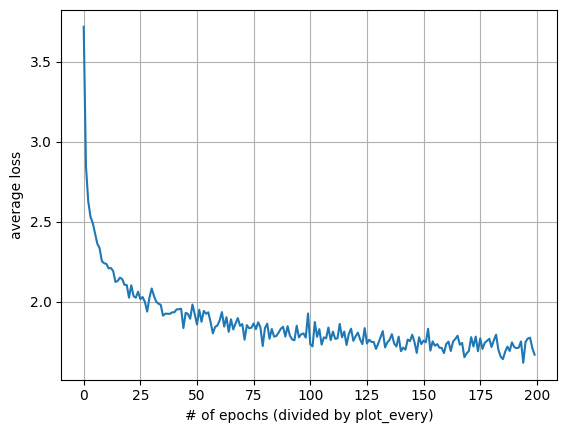

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.grid(True)
plt.xlabel('# of epochs (divided by plot_every)')
plt.ylabel('average loss')
plt.plot(all_losses)

### Model Evaluation - Calculating Perplexity (Q3)

In [13]:
import math
from unidecode import unidecode

def clean_text(text):
  text = unidecode(text)
  text = ''.join([c for c in text if c in all_characters])
  return text

def perplexity_char_rnn(model, text):
  model.eval()
  with torch.no_grad():
    tensor = chars_to_tensor(clean_text(text))

    inputs = tensor[:-1] # [c0, c1, ..., c_{T-2}]
    targets = tensor[1:] # [c1, c2, ..., c_{T-1}]

    hidden = model.init_hidden()
    total_neg_log_likelihood = 0
    M = len(inputs)
    cross_entropy_sum = nn.CrossEntropyLoss(reduction='sum')

    for i in range(M):
      output, hidden = model(inputs[i], hidden)
      loss = cross_entropy_sum(output, targets[i].view(-1))
      total_neg_log_likelihood += loss

    perplexity = math.exp(total_neg_log_likelihood / M)

    return perplexity


In [15]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
drive_directory = '/content/drive/My Drive/NLP_HW2'
os.chdir(drive_directory)

Mounted at /content/drive


In [16]:
with open("shakespeare_for_perplexity.txt", "r", encoding="utf-8") as f:
  shakespeare_text = f.read()
with open("wikipedia_for_perplexity.txt", "r", encoding="utf-8") as f:
  wiki_text = f.read()

ppl_shakespeare = perplexity_char_rnn(model, shakespeare_text)
ppl_wiki        = perplexity_char_rnn(model, wiki_text)

print(f"Perplexity of Shakespeare: {ppl_shakespeare}")
print(f"Perplexity of Wikipedia: {ppl_wiki}")

Perplexity of Shakespeare: 6.639272477616838
Perplexity of Wikipedia: 15.506264098669138
